### Import libraries for experiments

In [26]:
import torch
from src.training_main import training_main, test
from src.utils import data_loading, normalization, filter_extraction, plot_results, plot_kernels, plot_statistics, hist_statistics, loghist_statistics, mutual_information
from src.CNN import CNN
from src.ScatNet import ScatNet2D
from kymatio.torch import Scattering2D
from skimage.segmentation import mark_boundaries

from lime.lime_image import LimeImageExplainer
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

from torchvision.transforms import ToTensor, Compose, Resize, Normalize, ToPILImage
from captum.attr import IntegratedGradients
import cv2

import warnings
warnings.filterwarnings('ignore')


## Data Loading and Normalization

In [27]:
# LOAD DATA
train_data, train_labels, test_data, test_labels = data_loading("./data/train/", "./data/test/")
data = train_data + test_data

# NORMALIZATION
data_transform = normalization(data)

Red ch mean =  0.2082946035683011 
Green ch mean =  0.2082298517705837 
Blue ch mean =  0.2082241406070435
Red ch std =  0.2120124417706629 
Green ch std =  0.211990008277464 
Blue ch std =  0.2119912744425196


In [28]:
print(f"Length train data: {len(train_data)}, length train labels: {len(train_labels)}")
print(f"Length test data: {len(test_data)}, length test labels: {len(test_labels)}")

Length train data: 2600, length train labels: 2600
Length test data: 600, length test labels: 600


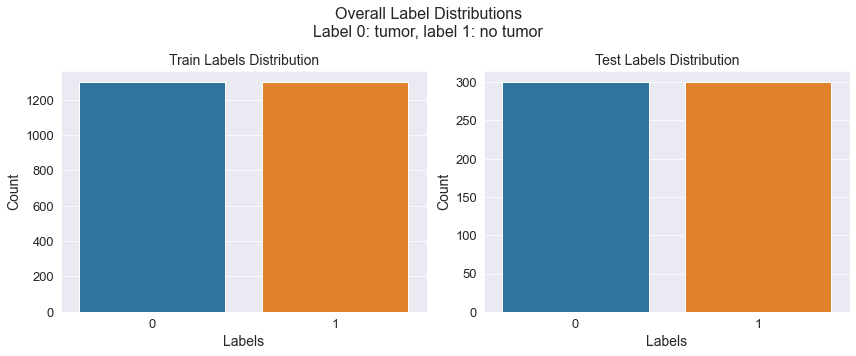

In [29]:
# Barplot to visualize the distribution of the labels 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Train labels
sns.countplot(x=train_labels, ax=ax1)
ax1.set_title('Train Labels Distribution', fontsize=14)
ax1.set_xlabel('Labels')
ax1.set_ylabel('Count')

# Test labels
sns.countplot(x=test_labels, ax=ax2)
ax2.set_title('Test Labels Distribution', fontsize=14)
ax2.set_xlabel('Labels')
ax2.set_ylabel('Count')

plt.suptitle('Overall Label Distributions\nLabel 0: tumor, label 1: no tumor', fontsize=16)
plt.tight_layout()
plt.show()


Example image

Image shape: (512, 512, 3)


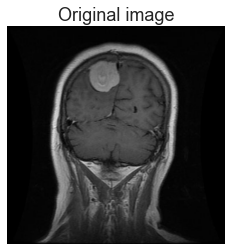

In [30]:
random.seed(42) 
image = random.sample(train_data, 1)
image = np.array(image)
image = np.squeeze(image, 0)
print(f"Image shape: {image.shape}")

plt.imshow(image)
plt.axis('off')
plt.title('Original image')
plt.show()

## CNN Classification

In [31]:
MODEL_NAME = 'CNN'
NUM_FOLD = 10
num_epochs = 20

In [32]:
# LOAD BEST MODEL
max_val_accuracies = np.zeros([NUM_FOLD, 1])

for i in range(NUM_FOLD):
    results_string = f"./csv/{MODEL_NAME}/results_df_" + str(i) + ".csv"
    max_val_accuracies[i] = np.max(pd.read_csv(results_string)["val_acc"])
    
indexCNN = np.argmax(max_val_accuracies)

model_string = f"./models_trained/{MODEL_NAME}/checkpoint_" + str(indexCNN) + ".pth"
checkpoint = torch.load(model_string, map_location=torch.device("cpu"))
model_CNN = CNN(input_channel=3, num_classes=2)
model_CNN.load_state_dict(checkpoint["model_state_dict"])
for parameter in model_CNN.parameters():
    parameter.requires_grad = False

print(f'CNN - Best fold n.{indexCNN}')

CNN - Best fold n.0


In [33]:
model_CNN

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (drop): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=256, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)

In [34]:
# PLOTTING RESULTS
train_accuracies = np.zeros([NUM_FOLD, num_epochs])
val_accuracies = np.zeros([NUM_FOLD, num_epochs])
train_losses = np.zeros([NUM_FOLD, num_epochs])
val_losses = np.zeros([NUM_FOLD, num_epochs])
f1_scores = np.zeros([NUM_FOLD, num_epochs])

for i in range(NUM_FOLD):
    results_string = f"./csv/{MODEL_NAME}/results_df_" + str(i) + ".csv"
    train_accuracies[i] = (pd.read_csv(results_string)["train_acc"]).to_list()
    val_accuracies[i] = (pd.read_csv(results_string)["val_acc"]).to_list()
    val_losses[i] = (pd.read_csv(results_string)["val_loss"]).to_list()
    train_losses[i] = (pd.read_csv(results_string)["train_loss"]).to_list()
    f1_scores[i] = (pd.read_csv(results_string)["val_f1"]).to_list()

plot_results(train_accuracies, val_accuracies, train_losses, val_losses, f1_scores, MODEL_NAME, indexCNN, show=False)

CNN - Test Accuracy 0.9816666666666667


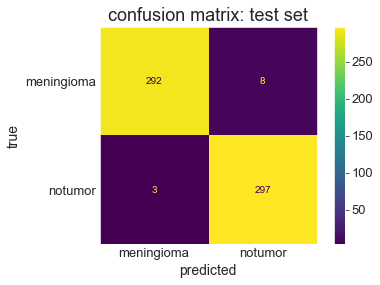

In [35]:
# TESTING
acc_CNN = test(data_transform, test_data, test_labels, model_CNN, MODEL_NAME, device='cpu')
print("CNN - Test Accuracy", acc_CNN)


### Extract Filters from CNN

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_CNN = model_CNN.to(device)

In [37]:
# Filter extraction
image = data_transform(image)
image = image.to(device)

single_channel = True if image.shape[0] == 1 else False
filter_extraction(model_CNN, MODEL_NAME, image, single_channel)

Total convolution layers: 4


## ScatNet Classification

In [38]:
MODEL_NAME = 'ScatNet'
NUM_FOLD = 10
num_epochs = 20

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [40]:
# LOAD BEST MODEL
max_val_accuracies = np.zeros([NUM_FOLD, 1])

for i in range(NUM_FOLD):
    results_string = f"./csv/{MODEL_NAME}/results_df_" + str(i) + ".csv"
    max_val_accuracies[i] = np.max(pd.read_csv(results_string)["val_acc"])
    
indexScatNet = np.argmax(max_val_accuracies)

model_string = f"./models_trained/{MODEL_NAME}/checkpoint_" + str(indexScatNet) + ".pth"
checkpoint = torch.load(model_string, map_location=torch.device("cpu"))

# Define best model
L = 8
J = 2
scattering = Scattering2D(J=J, shape=(128, 128), L=L)
K = 81  # Input channels for the ScatNet
scattering = scattering.to(device)
model_ScatNet = ScatNet2D(input_channels=K, scattering=scattering, num_classes=2).to(device)
model_ScatNet.load_state_dict(checkpoint["model_state_dict"])

for parameter in model_ScatNet.parameters():
    parameter.requires_grad = False

print(f'ScatNet - Best fold n.{indexScatNet}')

ScatNet - Best fold n.7


In [41]:
model_ScatNet

ScatNet2D(
  (scattering): Scattering2D()
  (lin): Linear(in_features=248832, out_features=576, bias=True)
  (classifier): Sequential(
    (0): Linear(in_features=576, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=32, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.1, inplace=False)
    (5): Linear(in_features=32, out_features=2, bias=True)
  )
)

In [42]:
# PLOTTING RESULTS
train_accuracies = np.zeros([NUM_FOLD, num_epochs])
val_accuracies = np.zeros([NUM_FOLD, num_epochs])
train_losses = np.zeros([NUM_FOLD, num_epochs])
val_losses = np.zeros([NUM_FOLD, num_epochs])
f1_scores = np.zeros([NUM_FOLD, num_epochs])

for i in range(NUM_FOLD):
    results_string = f"./csv/{MODEL_NAME}/results_df_" + str(i) + ".csv"
    val_accuracies[i] = (pd.read_csv(results_string)["val_acc"]).to_list()
    train_accuracies[i] = (pd.read_csv(results_string)["train_acc"]).to_list()
    val_losses[i] = (pd.read_csv(results_string)["val_loss"]).to_list()
    train_losses[i] = (pd.read_csv(results_string)["train_loss"]).to_list()
    f1_scores[i] = (pd.read_csv(results_string)["val_f1"]).to_list()

plot_results(train_accuracies, val_accuracies, train_losses, val_losses, f1_scores, MODEL_NAME, indexScatNet, show=False)

ScatNet - Test Accuracy 0.9666666666666667


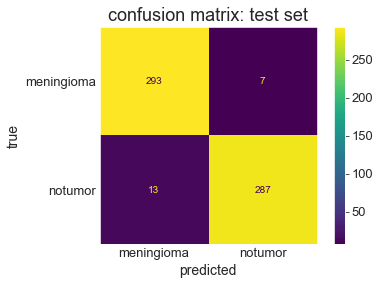

In [43]:
# TESTING
acc_ScatNet = test(data_transform, test_data, test_labels, model_ScatNet, MODEL_NAME, device='cpu')
print("ScatNet - Test Accuracy", acc_ScatNet)

### Extract Filters from ScatNet

In [44]:
# Filter extraction
model_ScatNet = model_ScatNet.to(device)
scatter = model_ScatNet.scattering
plot_kernels(J, L, scatter, MODEL_NAME)

--------------------------------------------------------------------
## INTEGRATED GRADIENTS

In [56]:
# IG SCRATCH
def ig_scratch(transformed_img, model, baseline, n_alpha):

    img = transformed_img.clone().to('cuda')
    baseline = baseline.to('cuda')
    model = model.to('cuda')

    difference_img_baseline = (img - baseline).squeeze(0).to('cuda')

    alphas = torch.linspace(0, 1, n_alpha + 1) 
    gradients_list = []

    model.eval()
    for alpha in alphas:
    
        baseline_x = baseline.unsqueeze(0).to('cuda')
        image_x = image.unsqueeze(0).to('cuda')
        difference_img_baseline = (image_x - baseline_x).to('cuda')
        input = baseline_x + alpha * difference_img_baseline

        model.zero_grad()
        input = input.clone().detach().requires_grad_(True)

        output = model(input.squeeze(0).to('cuda'))
        probs = torch.nn.functional.softmax(output, dim=1)[:,1]
        
        gradients = torch.autograd.grad(probs, input, 
                                    grad_outputs=torch.ones_like(probs),
                                    create_graph=True)[0]
        
        gradients_list.append(gradients)

    total_gradients = torch.cat(gradients_list, dim=0).to('cuda')
    grads = (total_gradients[:-1] + total_gradients[1:]) / torch.Tensor([2.0]).to('cuda')

    avg_gradients = torch.mean(grads.detach(), axis=0)
    integrated_gradients = (image - baseline) * avg_gradients

    return integrated_gradients
   

In [57]:
# IG CAPTUM
def ig_captum(transformed_img, model, baseline, n_alpha):
    img = transformed_img.to('cuda')
    model = model.to('cuda')
    baseline = baseline.to('cuda')

    ig = IntegratedGradients(model)
    attributions, delta = ig.attribute(img, baseline, target=0, return_convergence_delta=True, n_steps=n_alpha)

    return attributions

Test and plot the attributions for 3 different images from test folder.

In [45]:
num_images = 3
images = []
images.append(cv2.imread('./data/test/meningioma/Te-me_0026.jpg')) # TUMOR
images.append(cv2.imread('./data/test/notumor/Te-no_0102.jpg')) # NO TUMOR
images.append(cv2.imread('./data/test/meningioma/Te-me_0147.jpg')) #  TUMOR

labels = [0,1,0]


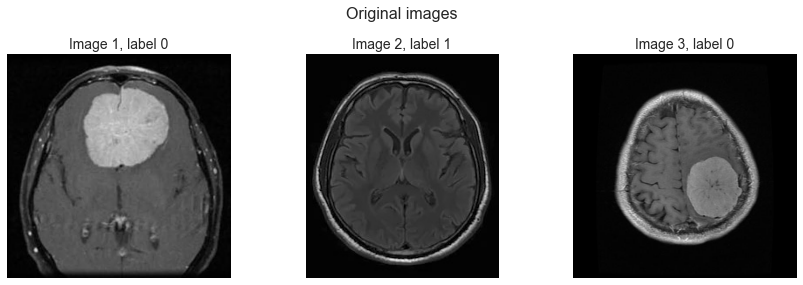

In [46]:
#Plot images
fig, axs = plt.subplots(1, num_images, figsize=(12, 4))

for i in range(num_images):
    image = images[i]
    label = labels[i]

    axs[i].imshow(image)
    axs[i].axis('off')
    axs[i].set_title(f'Image {i+1}, label {label}', fontsize=14)

plt.suptitle('Original images', fontsize=16)
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


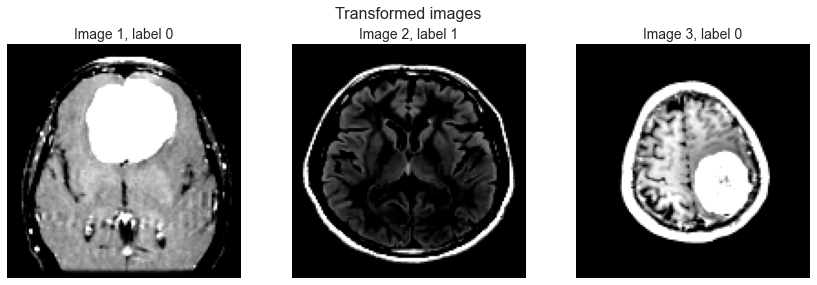

In [47]:
# Apply transform to images
for i in range(num_images):
    images[i] = data_transform(images[i]).unsqueeze(0)

# Plot
fig, axs = plt.subplots(1, num_images, figsize=(12, 4))
for i in range(num_images):
    image = np.squeeze(np.array(images[i]), 0).transpose(1, 2, 0)
    label = labels[i]
    
    axs[i].imshow(image)
    axs[i].axis('off')
    axs[i].set_title(f'Image {i+1}, label {label}', fontsize=14)

plt.suptitle('Transformed images', fontsize=16)
plt.tight_layout()
plt.show()

### Baseline choices

In [48]:
baseline_zeros = torch.zeros(1, 3, 128, 128)
baseline_uniform = torch.rand(1, 3, 128, 128)

tensor_images = torch.stack([data_transform(img) for img in train_data])
baseline_mean = torch.mean(tensor_images, dim=0, keepdim=True)

baselines = [baseline_zeros, baseline_uniform, baseline_mean]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


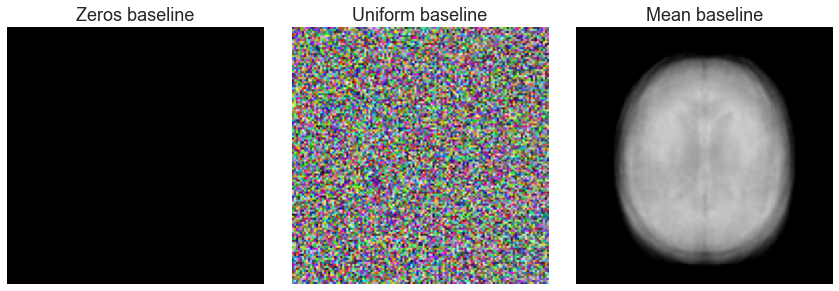

In [49]:
# Plot baselines
fig, axs = plt.subplots(1, len(baselines), figsize=(12, 4))
titles = ['Zeros baseline', 'Uniform baseline', 'Mean baseline']

for i in range(len(baselines)):
    baseline = baselines[i]

    axs[i].imshow(baseline.squeeze().permute(1, 2, 0))
    axs[i].axis('off')
    axs[i].set_title(f'{titles[i]}')

plt.tight_layout()
plt.show()

### Checking neutrality of baselines

In [50]:
print('CNN MODEL')
for i in range(len(baselines)):
    image = baselines[i].to('cuda')

    model_CNN.eval()
    
    with torch.inference_mode():
        pred = model_CNN(image)
    probs = torch.softmax(pred, dim=1)

    print("Baseline: ", titles[i])
    print("Output prediction probabilities: ", probs)

print('\nScatNet MODEL')
for i in range(len(baselines)):
    image = baselines[i].to('cuda')

    model_ScatNet.eval()
    
    with torch.inference_mode():
        pred = model_ScatNet(image)
    probs = torch.softmax(pred, dim=1)

    print("Baseline: ", titles[i])
    print("Output prediction probabilities: ", probs)


CNN MODEL
Baseline:  Zeros baseline
Output prediction probabilities:  tensor([[0.3617, 0.6383]], device='cuda:0')
Baseline:  Uniform baseline
Output prediction probabilities:  tensor([[0.1085, 0.8915]], device='cuda:0')
Baseline:  Mean baseline
Output prediction probabilities:  tensor([[0.8844, 0.1156]], device='cuda:0')

ScatNet MODEL
Baseline:  Zeros baseline
Output prediction probabilities:  tensor([[0.4594, 0.5406]], device='cuda:0')
Baseline:  Uniform baseline
Output prediction probabilities:  tensor([[0.0065, 0.9935]], device='cuda:0')
Baseline:  Mean baseline
Output prediction probabilities:  tensor([[0.9980, 0.0020]], device='cuda:0')


### We'll keep only the neutral baseline

In [51]:
final_baseline = baselines[0]
final_title = titles[0]

### How to plot attributions

In [52]:
# Attribution plot
def plot_attributions(image, baseline, attribution, title):

    image = image.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()

    fig, axis = plt.subplots(nrows=1, ncols=4, figsize=(12, 10))

    baseline = baseline.squeeze().permute(1, 2, 0)
    ig_captum = attribution[0].cpu()
    ig_scratch = attribution[1]

    axis[0].imshow(baseline)
    axis[0].set_xticks([])
    axis[0].set_yticks([])
    axis[0].set_title(title, fontsize=14)

    axis[1].imshow(image)
    axis[1].set_xticks([])
    axis[1].set_yticks([])
    axis[1].set_title('Original', fontsize=14)

    im2 = axis[2].imshow(image)
    im2 = axis[2].imshow(ig_captum, cmap='hot', alpha=0.9)
    axis[2].axis('off')
    axis[2].set_title('IG Captum', fontsize=14)
    divider = make_axes_locatable(axis[2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im2, cax=cax, orientation='vertical')

    im3 = axis[3].imshow(image)
    im3 = axis[3].imshow(ig_scratch, cmap='hot', alpha=0.9)
    axis[3].axis('off')
    axis[3].set_title('IG Scratch', fontsize=14)

    divider = make_axes_locatable(axis[3])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im3, cax=cax, orientation='vertical')

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.2)
    plt.show()

In [53]:
n_alpha = 100

### Attributions for CNN model

In [54]:
# CNN model
print('CNN MODEL')
predictions = []
for i in range(num_images):
    print(f'Image {i+1}')
    image = images[i].to('cuda')
    label = labels[i]

    model_CNN.eval()
    model_CNN.to('cuda')
    with torch.inference_mode():
        pred = model_CNN(image)
        
    probs = torch.softmax(pred, dim=1)
    prediction = torch.argmax(torch.softmax(pred, dim=1), dim=1)
    predictions.append(prediction)
    # model logits -> pred probs -> pred label
    print("Output logits: ", pred)
    print("Output prediction probabilities: ", probs)
    print(f'Output prediction label: {prediction} --> Prediction class: {"NO TUMOR" if prediction.cpu() == 1 else "TUMOR"}')
    print(f'Actual label: {label} --> True class: {"NO TUMOR" if label == 1 else "TUMOR"}\n')

CNN MODEL
Image 1
Output logits:  tensor([[ 6.5909, -5.1883]], device='cuda:0')
Output prediction probabilities:  tensor([[9.9999e-01, 7.6623e-06]], device='cuda:0')
Output prediction label: tensor([0], device='cuda:0') --> Prediction class: TUMOR
Actual label: 0 --> True class: TUMOR

Image 2
Output logits:  tensor([[-2.6648,  5.7402]], device='cuda:0')
Output prediction probabilities:  tensor([[2.2370e-04, 9.9978e-01]], device='cuda:0')
Output prediction label: tensor([1], device='cuda:0') --> Prediction class: NO TUMOR
Actual label: 1 --> True class: NO TUMOR

Image 3
Output logits:  tensor([[ 8.9662, -8.1972]], device='cuda:0')
Output prediction probabilities:  tensor([[1.0000e+00, 3.5156e-08]], device='cuda:0')
Output prediction label: tensor([0], device='cuda:0') --> Prediction class: TUMOR
Actual label: 0 --> True class: TUMOR



Image 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


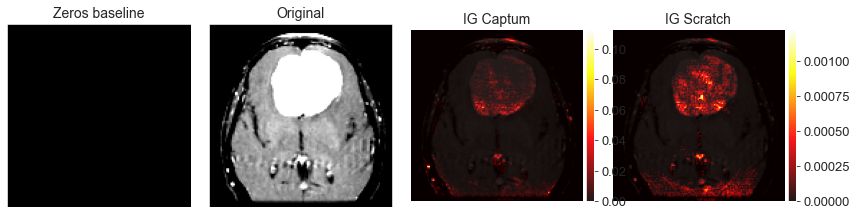

Image 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


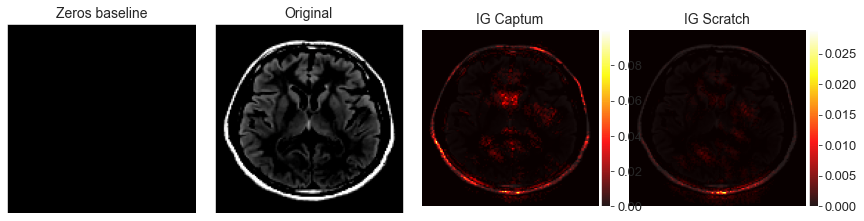

Image 3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


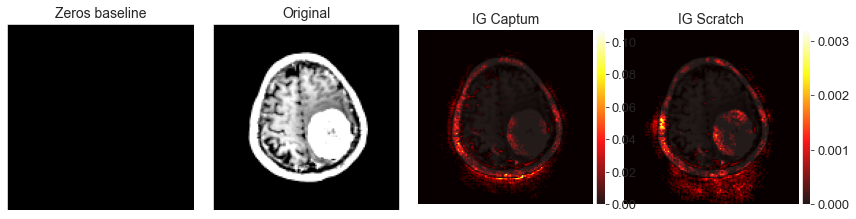

In [58]:
# Compute Integrated Gradients attributions for each baseline (Captum and scratch)
for i in range(num_images):
    print(f'Image {i+1}')
    image = images[i].to('cuda')
    
    attributions = []
    attribution_captum = ig_captum(image, model_CNN, baseline, n_alpha)
    attribution_captum = torch.sum(torch.abs(attribution_captum), dim=1)
    attribution_captum = attribution_captum.squeeze()

    p_85 = np.percentile(attribution_captum.cpu(), 85)
    attribution_captum[attribution_captum < p_85] = 0
    attributions.append(attribution_captum)


    attribution_scratch = ig_scratch(image, model_CNN, baseline, n_alpha)
    attribution_scratch = torch.sum(torch.abs(attribution_scratch), dim=1)
    attribution_scratch = np.transpose(attribution_scratch.cpu().detach().numpy(), (1, 2, 0))
    p_85 = np.percentile(attribution_scratch, 85)
    attribution_scratch[attribution_scratch < p_85] = 0
    attributions.append(attribution_scratch)

    plot_attributions(image, final_baseline, attributions, final_title)

In [77]:
torch.cuda.empty_cache()

### Attributions for ScatNet model

In [59]:
# ScatNet model
print('SCATNET MODEL')
for i in range(num_images):
    print(f'Image {i+1}')
    image = images[i].to('cuda')
    label = labels[i]
    model_ScatNet.to('cuda')
    model_ScatNet.eval()
    with torch.inference_mode():
        pred = model_ScatNet(image)
        
    probs = torch.softmax(pred, dim=1)
    prediction = torch.argmax(torch.softmax(pred, dim=1), dim=1)

    # model logits -> pred probs -> pred label
    print("Output logits: ", pred)
    print("Output prediction probabilities: ", probs)
    print(f'Output prediction label: {prediction} --> Prediction class: {"NO TUMOR" if prediction.cpu() == 1 else "TUMOR"}')
    print(f'Actual label: {label} --> True class: {"NO TUMOR" if label == 1 else "TUMOR"}\n')

SCATNET MODEL
Image 1
Output logits:  tensor([[ 5.4345, -0.2059]], device='cuda:0')
Output prediction probabilities:  tensor([[0.9965, 0.0035]], device='cuda:0')
Output prediction label: tensor([0], device='cuda:0') --> Prediction class: TUMOR
Actual label: 0 --> True class: TUMOR

Image 2
Output logits:  tensor([[-1.9169,  4.0644]], device='cuda:0')
Output prediction probabilities:  tensor([[0.0025, 0.9975]], device='cuda:0')
Output prediction label: tensor([1], device='cuda:0') --> Prediction class: NO TUMOR
Actual label: 1 --> True class: NO TUMOR

Image 3
Output logits:  tensor([[12.8477, -2.9030]], device='cuda:0')
Output prediction probabilities:  tensor([[1.0000e+00, 1.4439e-07]], device='cuda:0')
Output prediction label: tensor([0], device='cuda:0') --> Prediction class: TUMOR
Actual label: 0 --> True class: TUMOR



Image 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


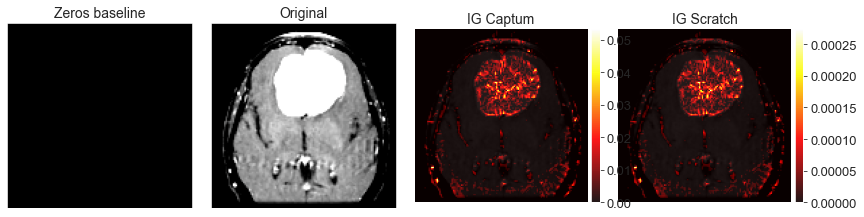

Image 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


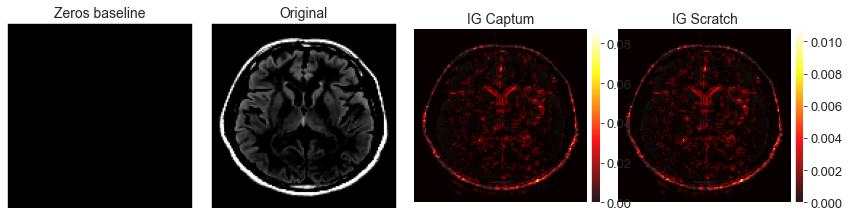

Image 3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


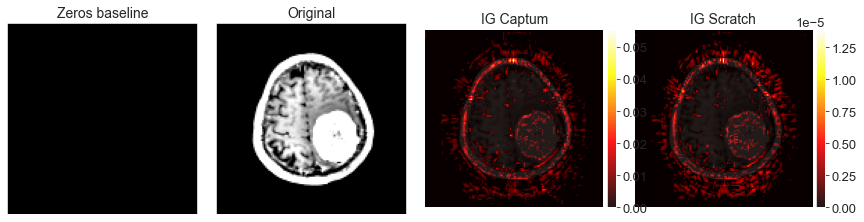

In [60]:
# CHECK HERE, A LOT INCREASING MEMORY !!!!!
# Compute Integrated Gradients attributions for each baseline (Captum and scratch)
for i in range(num_images):
    print(f'Image {i+1}')
    image = images[i].to('cuda')
    
    attributions = []
    attribution_captum = ig_captum(image, model_ScatNet, baseline, n_alpha)
    attribution_captum = torch.sum(torch.abs(attribution_captum), dim=1)
    attribution_captum = attribution_captum.squeeze()

    p_95 = np.percentile(attribution_captum.cpu(), 85)
    attribution_captum[attribution_captum < p_95] = 0
    attributions.append(attribution_captum)


    attribution_scratch = ig_scratch(image, model_ScatNet, baseline, n_alpha)
    attribution_scratch = torch.sum(torch.abs(attribution_scratch), dim=1)
    attribution_scratch = np.transpose(attribution_scratch.cpu().detach().numpy(), (1, 2, 0))
    p_95 = np.percentile(attribution_scratch, 85)
    attribution_scratch[attribution_scratch < p_95] = 0
    attributions.append(attribution_scratch)

    plot_attributions(image, final_baseline, attributions, final_title)

--------------------------------------------------------------------
## LIME

In [61]:
# Attribution plot
def plot_lime(image, img1, img2):

    # REMOVE WHEN THERE ARE MORE THAN 1 IMAGE --> TO AVOID REMOVE i VARIABLE EVERYWHERE
    image = image.reshape(1, 128, 128, 3)
    img1 = img1.reshape(1, 128, 128, 3)
    img2 = img2.reshape(1, 128, 128, 3)
    # REMOVE WHEN THERE ARE MORE THAN 1 IMAGE  --> TO AVOID REMOVE i VARIABLE EVERYWHERE

    fig, axis = plt.subplots(len(image), 3, figsize=(12, 10))

    for i in range(image.shape[0]):

        axis[0].imshow(image[i])  # .cpu().detach().numpy())
        axis[0].set_xticks([])
        axis[0].set_yticks([])
        # axis[i, 0].set_title(titles[i], fontsize=14)

        # im2 = axis[i, 1].imshow(image)
        im2 = axis[1].imshow(img1[i].reshape(128, 128, 3), cmap='inferno', alpha=0.9)
        axis[1].axis('off')
        axis[1].set_title('Mask Positive', fontsize=14)
        # divider = make_axes_locatable(axis[1])
        # cax = divider.append_axes('right', size='5%', pad=0.05)
        # fig.colorbar(im2, cax=cax, orientation='vertical')

        # im3 = axis[i, 2].imshow(image)
        im3 = axis[2].imshow(img2[i].reshape(128, 128, 3), cmap='inferno', alpha=0.8)
        # im3 = axis[i, 2].imshow(ig_scratch.squeeze(0).permute(1,2,0).cpu(), cmap='jet', alpha=0.9)
        axis[2].axis('off')
        axis[2].set_title('Mask Positive and Negative', fontsize=14)

        # divider = make_axes_locatable(axis[2])
        # cax = divider.append_axes('right', size='5%', pad=0.05)
        # fig.colorbar(im3, cax=cax, orientation='vertical')

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.2)
    plt.show()

In [62]:
def batch_predict_CNN(images):
    model_CNN.eval()
    data = torch.tensor(images).view(images.shape[0],images.shape[3],images.shape[1],images.shape[2])
    data = data.to('cuda')
    logits = model_CNN(data)
    data = data.detach()
    probs = torch.nn.functional.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

def batch_predict_ScatNet(images):
    model_ScatNet.eval()
    data = torch.tensor(images).view(images.shape[0],images.shape[3],images.shape[1],images.shape[2])
    data = data.to('cuda')
    logits = model_ScatNet(data)
    data = data.detach()
    probs = torch.nn.functional.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [63]:
lime_explainer = LimeImageExplainer(kernel_width=0.25, #kernel=None,
                                    verbose=False, feature_selection='auto', random_state=None)

In [86]:
def lime_execute_and_plot(model_forward, image, label):
    image_original = np.transpose(np.array(image.squeeze(0)), (1, 2, 0))

    lime_inst_exp = lime_explainer.explain_instance(image_original, model_forward, num_features=10)

    temp, mask = lime_inst_exp.get_image_and_mask(not label, positive_only=True, num_features=5,
                                                hide_rest=True)
    temp = (temp - temp.min()) / (temp.max() - temp.min())
    image_lime1 = mark_boundaries(temp, mask)

    temp, mask = lime_inst_exp.get_image_and_mask(not label, positive_only=False, num_features=5,
                                                hide_rest=True)

    temp = (temp - temp.min()) / (temp.max() - temp.min())
    image_lime2 = mark_boundaries(temp, mask)

    if label == 0:
        print('TUMOR')
    else:
        print(' NO TUMOR')

    plot_lime(image_original, image_lime1, image_lime2)
            
    return image_lime1

### CNN Lime

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


TUMOR


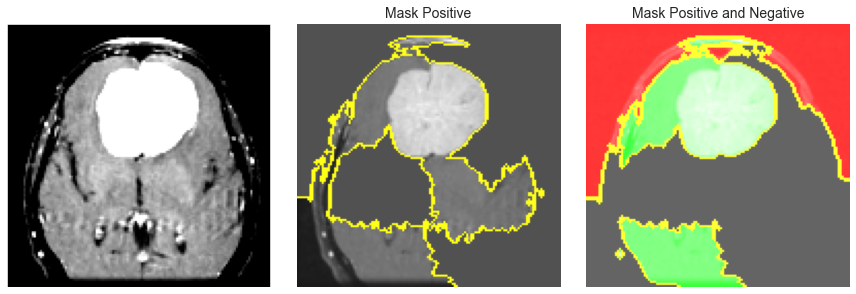

In [87]:
lime1_tumor1_CNN = lime_execute_and_plot(batch_predict_CNN, images[0], labels[0])

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 NO TUMOR


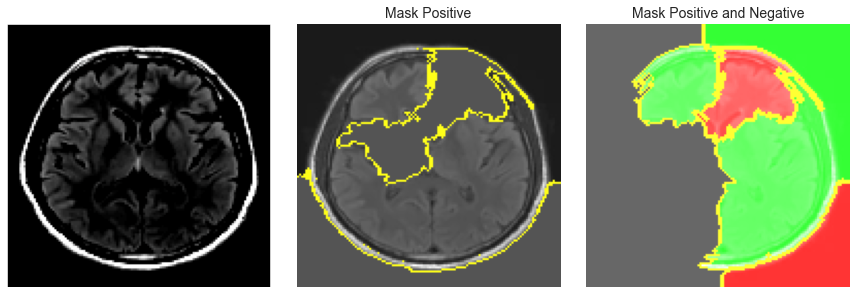

In [88]:
lime1_notumor_CNN = lime_execute_and_plot(batch_predict_CNN, images[1], labels[1])

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


TUMOR


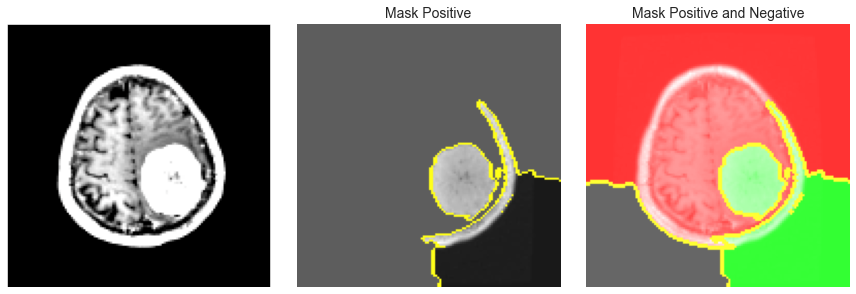

In [89]:
lime1_tumor2_CNN = lime_execute_and_plot(batch_predict_CNN, images[2], labels[2])

### ScatNet LIME

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


TUMOR


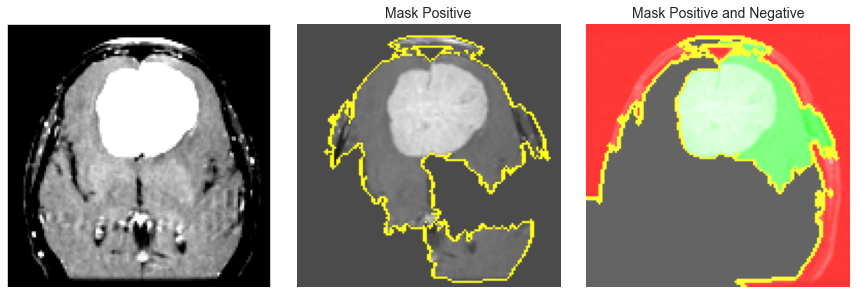

In [90]:
lime1_tumor1_ScatNet = lime_execute_and_plot(batch_predict_ScatNet, images[0], labels[0])

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 NO TUMOR


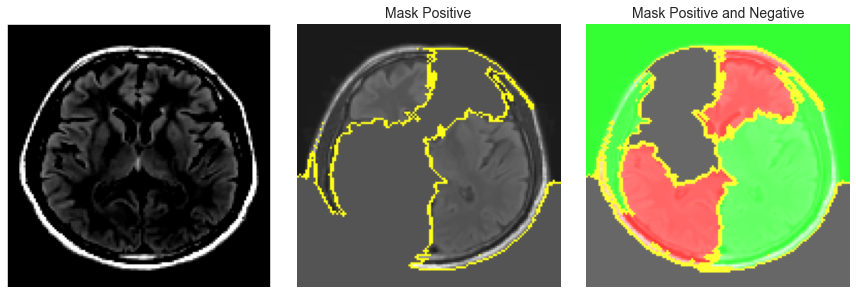

In [91]:
lime1_notumor_ScatNet = lime_execute_and_plot(batch_predict_ScatNet, images[1], labels[1])

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


TUMOR


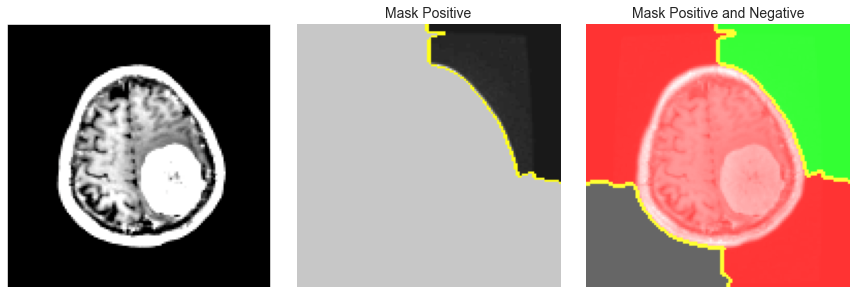

In [92]:
lime1_tumor2_ScatNet = lime_execute_and_plot(batch_predict_ScatNet, images[2], labels[2])

---------------------------------------------------------------------------------
# Comparing XAI methods - Statistics

### Comparing experiments with prediction from CNN

In [48]:
baseline = baselines[0]

attribution_scratch_tumor1_CNN = ig_scratch(images[0].to('cuda'), model_CNN, baseline, n_alpha)
attribution_captum_tumor1_CNN = ig_captum(images[0].to('cuda'), model_CNN, baseline, n_alpha)
image_tumor1_CNN = np.transpose(np.array(images[0].squeeze(0)), (1, 2, 0))

attribution_scratch_notumor_CNN = ig_scratch(images[1].to('cuda'), model_CNN, baseline, n_alpha)
attribution_captum_notumor_CNN = ig_captum(images[1].to('cuda'), model_CNN, baseline, n_alpha)
image_notumor_CNN = np.transpose(np.array(images[1].squeeze(0)), (1, 2, 0))

attribution_scratch_tumor2_CNN = ig_scratch(images[2].to('cuda'), model_CNN, baseline, n_alpha)
attribution_captum_tumor2_CNN = ig_captum(images[2].to('cuda'), model_CNN, baseline, n_alpha)
image_tumor2_CNN = np.transpose(np.array(images[2].squeeze(0)), (1, 2, 0))

Text(0.5, 0.98, 'One-dimensional histograms of the attribution maps with CNN')

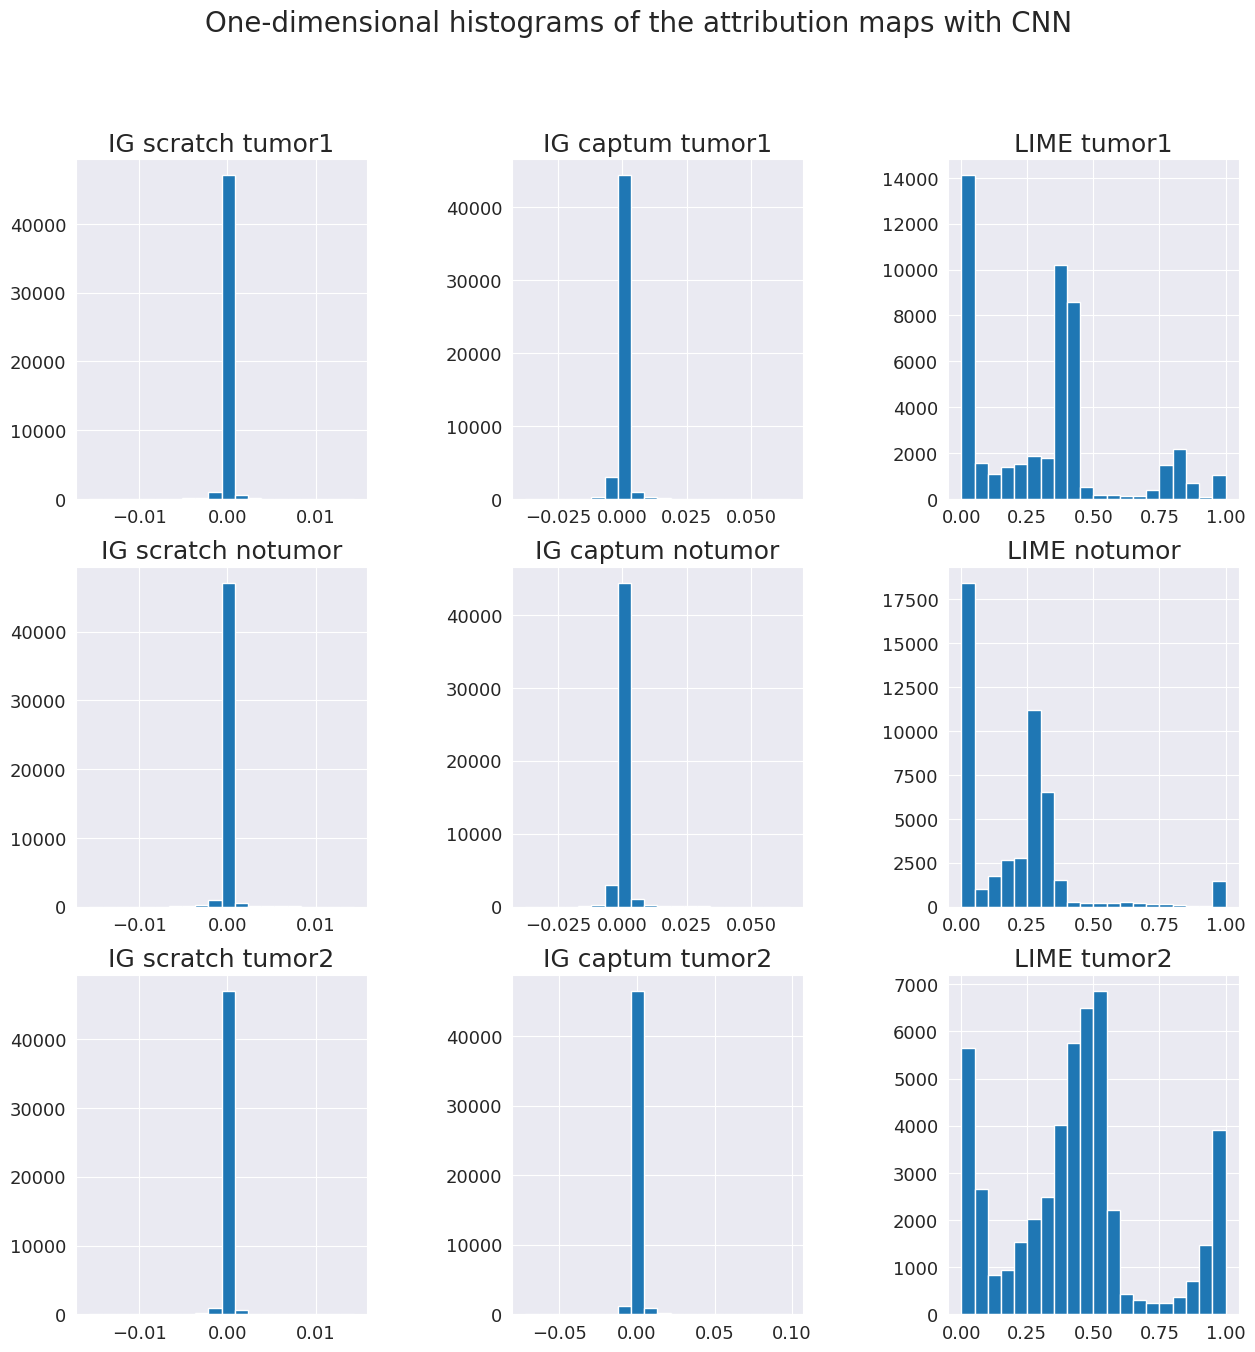

In [49]:
fig,axes = plt.subplots(ncols=3,nrows=3, figsize=(15, 15), gridspec_kw = {'wspace':0.5, 'hspace':0.2})

axes[0][0].hist(attribution_scratch_tumor1_CNN.cpu().ravel(),bins=20)
axes[0][0].set_title("IG scratch tumor1")
axes[0][1].hist(attribution_captum_tumor1_CNN.cpu().ravel(),bins=20)
axes[0][1].set_title("IG captum tumor1")
axes[0][2].hist(lime1_tumor1_CNN.ravel(), bins=20)
axes[0][2].set_title("LIME tumor1")

axes[1][0].hist(attribution_scratch_notumor_CNN.cpu().ravel(),bins=20)
axes[1][0].set_title("IG scratch notumor")
axes[1][1].hist(attribution_captum_tumor1_CNN.cpu().ravel(),bins=20)
axes[1][1].set_title("IG captum notumor")
axes[1][2].hist(lime1_notumor_CNN.ravel(), bins=20)
axes[1][2].set_title("LIME notumor")

axes[2][0].hist(attribution_scratch_tumor2_CNN.cpu().ravel(),bins=20)
axes[2][0].set_title("IG scratch tumor2")
axes[2][1].hist(attribution_captum_tumor2_CNN.cpu().ravel(),bins=20)
axes[2][1].set_title("IG captum tumor2")
axes[2][2].hist(lime1_tumor2_CNN.ravel(), bins=20)
axes[2][2].set_title("LIME tumor2")

fig.suptitle("One-dimensional histograms of the attribution maps with CNN", fontsize=20) 

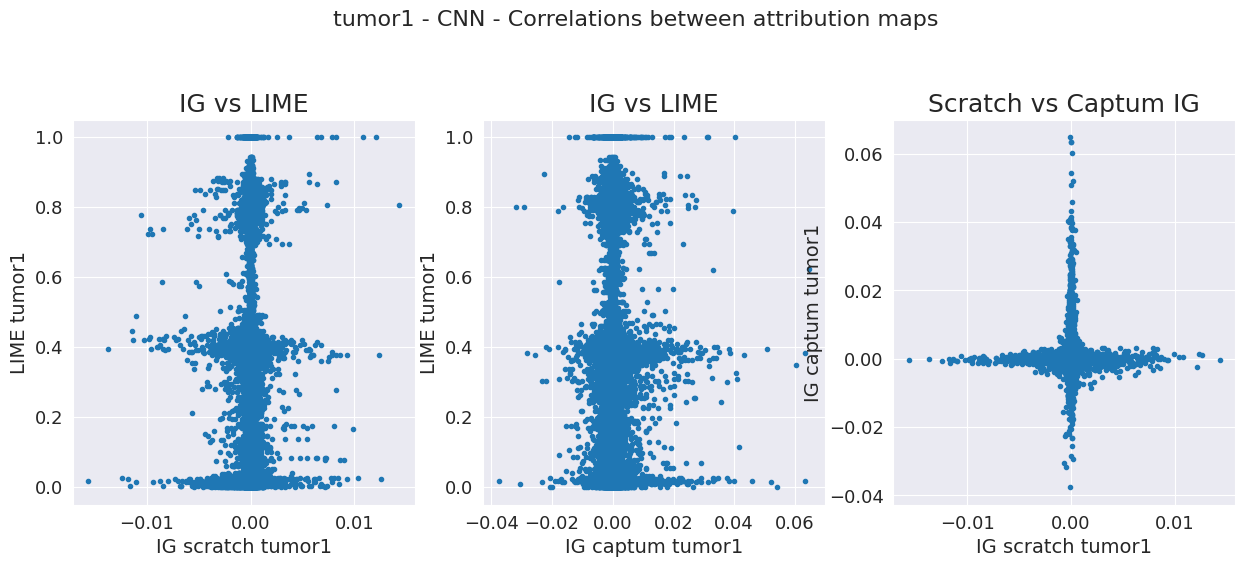

In [50]:
plot_statistics(attribution_scratch_tumor1_CNN.cpu().ravel(), lime1_tumor1_CNN.ravel(), attribution_captum_tumor1_CNN.cpu().ravel(), 
                'tumor1', 'Correlations between attribution maps', 'CNN')

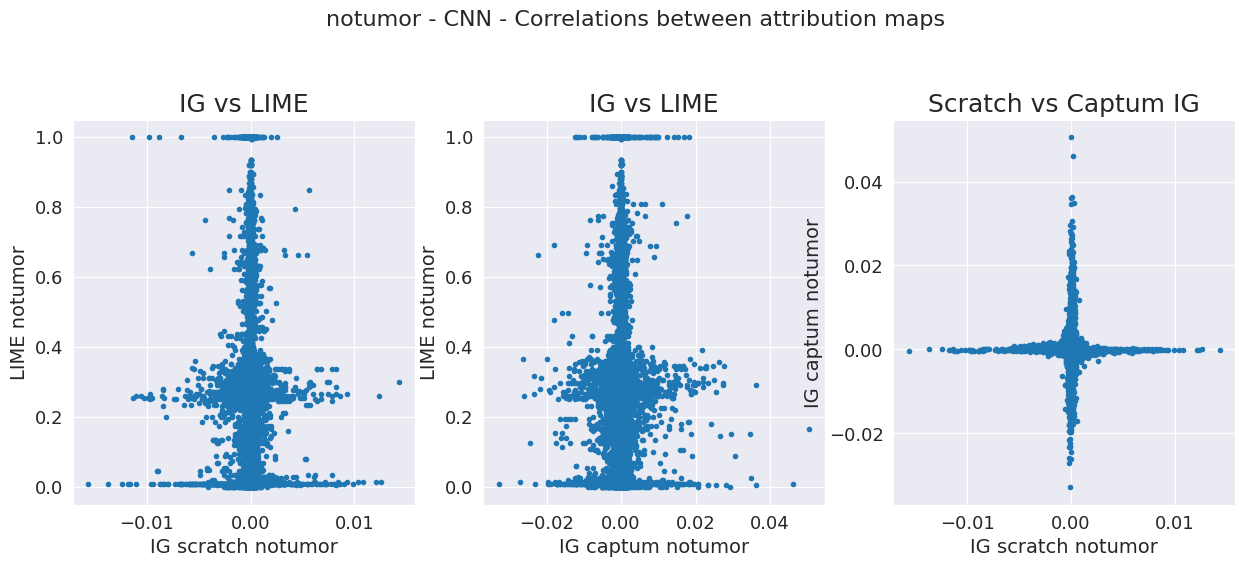

In [51]:
plot_statistics(attribution_scratch_notumor_CNN.cpu().ravel(), lime1_notumor_CNN.ravel(), attribution_captum_notumor_CNN.cpu().ravel(), 
                'notumor', 'Correlations between attribution maps', 'CNN')

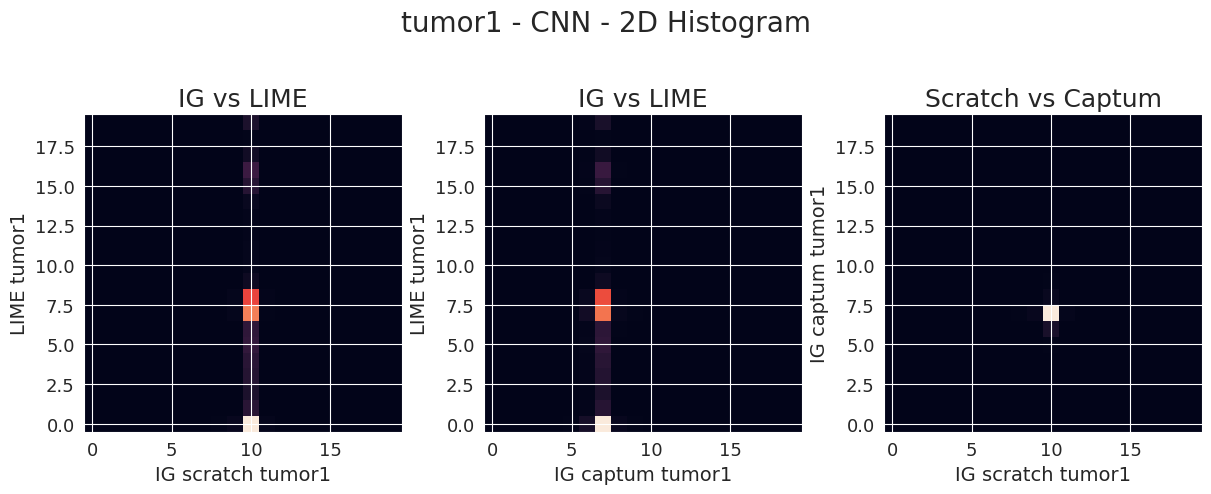

In [52]:
hist_statistics(attribution_scratch_tumor1_CNN.cpu().ravel(), lime1_tumor1_CNN.ravel(), attribution_captum_tumor1_CNN.cpu().ravel(), 
                'tumor1', '2D Histogram', 'CNN')

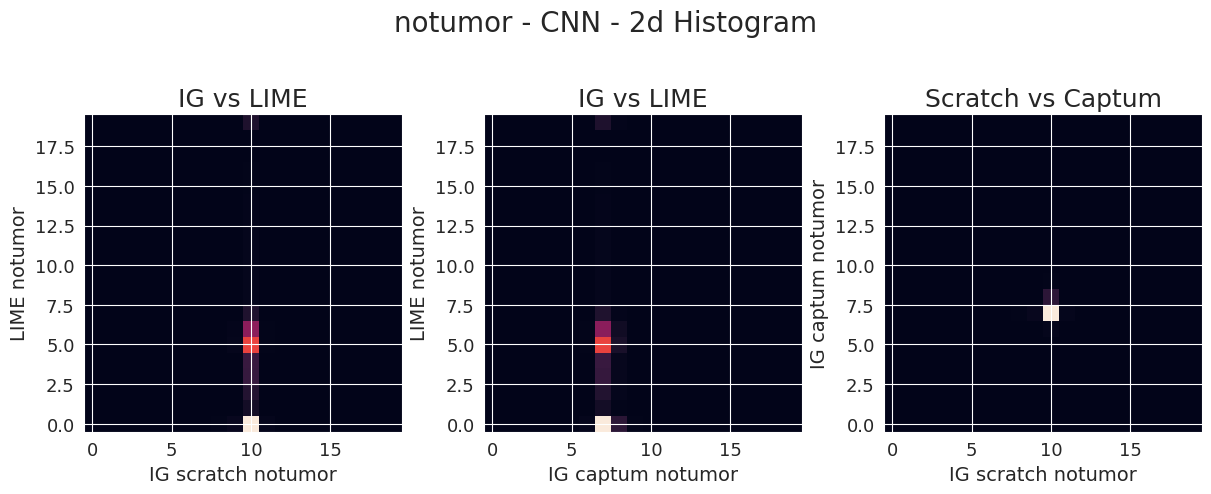

In [53]:
hist_statistics(attribution_scratch_notumor_CNN.cpu().ravel(), lime1_notumor_CNN.ravel(), attribution_captum_notumor_CNN.cpu().ravel(), 
                'notumor', '2d Histogram', 'CNN')

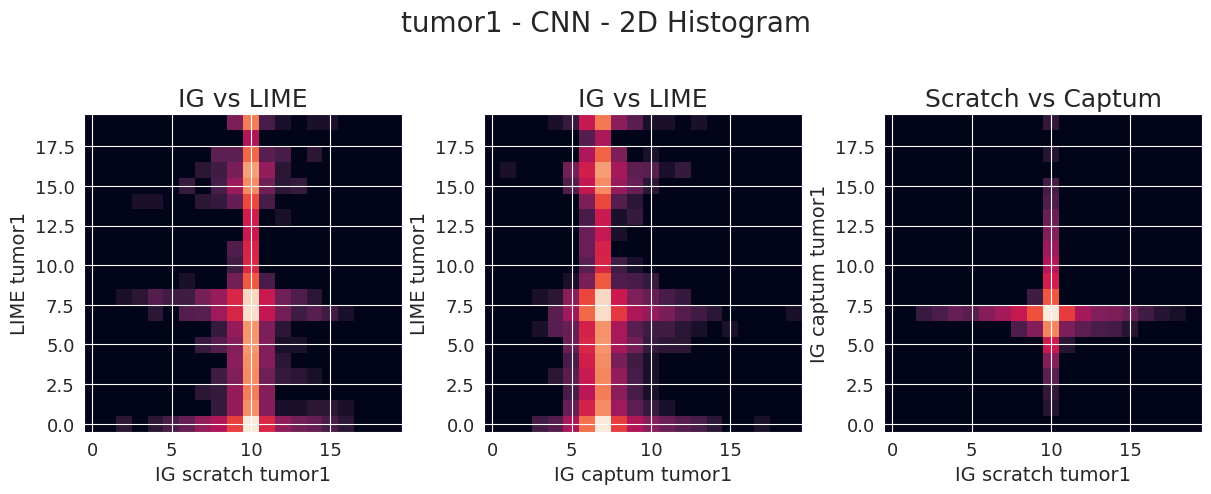

In [54]:
loghist_statistics(attribution_scratch_tumor1_CNN.cpu().ravel(), lime1_tumor1_CNN.ravel(), attribution_captum_tumor1_CNN.cpu().ravel(), 
                'tumor1', '2D Histogram', 'CNN')

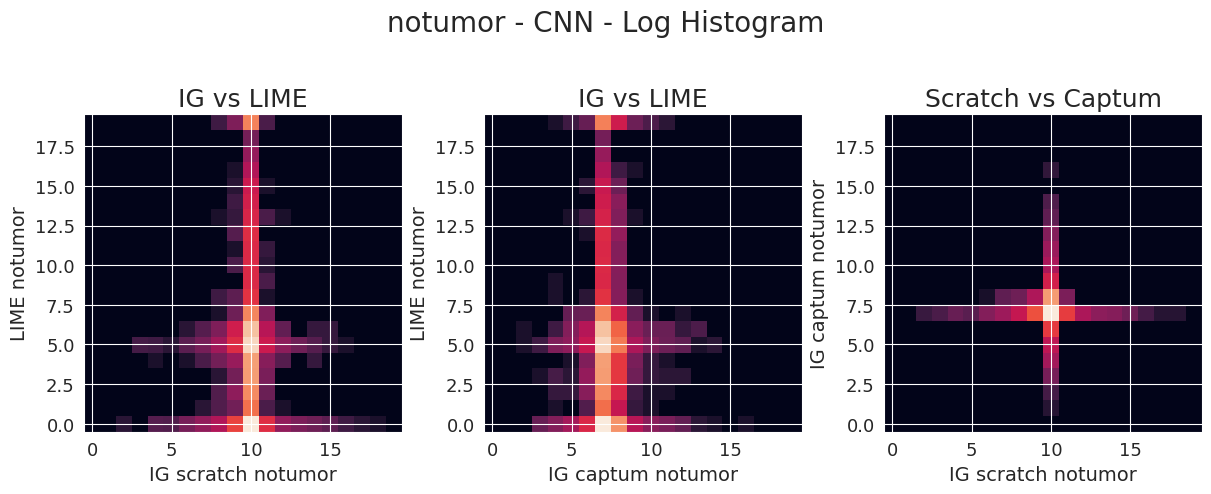

In [55]:
loghist_statistics(attribution_scratch_notumor_CNN.cpu().ravel(), lime1_notumor_CNN.ravel(), attribution_captum_notumor_CNN.cpu().ravel(), 
                'notumor', 'Log Histogram', 'CNN')

In [56]:
print('TUMOR MUTUAL INFORMATION CNN')
hist_2d, x_edges, y_edges = np.histogram2d(attribution_scratch_tumor1_CNN.cpu().ravel(),attribution_captum_tumor1_CNN.cpu().ravel(),bins=20)
print("The mutual information between IG Scratch and IG Captum is: ",mutual_information(hist_2d))
hist_2d, x_edges, y_edges = np.histogram2d(attribution_scratch_tumor1_CNN.cpu().ravel(),lime1_tumor1_CNN.ravel(),bins=20)
print("The mutual information between IG Scratch and LIME is: ",mutual_information(hist_2d))
hist_2d, x_edges, y_edges = np.histogram2d(attribution_captum_tumor1_CNN.cpu().ravel(),lime1_tumor1_CNN.ravel(),bins=20)
print("The mutual information between IG Captum and LIME is: ",mutual_information(hist_2d))

print('\nNO TUMOR MUTUAL INFORMATION CNN')
hist_2d, x_edges, y_edges = np.histogram2d(attribution_scratch_notumor_CNN.cpu().ravel(),attribution_captum_notumor_CNN.cpu().ravel(),bins=20)
print("The mutual information between IG Scratch and IG Captum is: ",mutual_information(hist_2d))
hist_2d, x_edges, y_edges = np.histogram2d(attribution_scratch_notumor_CNN.cpu().ravel(),lime1_notumor_CNN.ravel(),bins=20)
print("The mutual information between IG Scratch and LIME is: ",mutual_information(hist_2d))
hist_2d, x_edges, y_edges = np.histogram2d(attribution_captum_notumor_CNN.cpu().ravel(),lime1_notumor_CNN.ravel(),bins=20)
print("The mutual information between IG Captum and LIME is: ",mutual_information(hist_2d))

TUMOR MUTUAL INFORMATION CNN
The mutual information between IG Scratch and IG Captum is:  0.0018059689542767017
The mutual information between IG Scratch and LIME is:  0.0041111849722002
The mutual information between IG Captum and LIME is:  0.005794171004468707

NO TUMOR MUTUAL INFORMATION CNN
The mutual information between IG Scratch and IG Captum is:  0.0018163724117638425
The mutual information between IG Scratch and LIME is:  0.0036490721048285384
The mutual information between IG Captum and LIME is:  0.0027699557247285378


### Comparing experiments with prediction from ScatNet

In [57]:
baseline = baselines[0]

attribution_scratch_tumor1_ScatNet = ig_scratch(images[0].to('cuda'), model_ScatNet, baseline, n_alpha)
attribution_captum_tumor1_ScatNet = ig_captum(images[0].to('cuda'), model_ScatNet, baseline, n_alpha)
image_tumor1_ScatNet = np.transpose(np.array(images[0].squeeze(0)), (1, 2, 0))

attribution_scratch_notumor_ScatNet = ig_scratch(images[1].to('cuda'), model_ScatNet, baseline, n_alpha)
attribution_captum_notumor_ScatNet = ig_captum(images[1].to('cuda'), model_ScatNet, baseline, n_alpha)
image_notumor_ScatNet = np.transpose(np.array(images[1].squeeze(0)), (1, 2, 0))

attribution_scratch_tumor2_ScatNet = ig_scratch(images[2].to('cuda'), model_ScatNet, baseline, n_alpha)
attribution_captum_tumor2_ScatNet = ig_captum(images[2].to('cuda'), model_ScatNet, baseline, n_alpha)
image_tumor2_ScatNet = np.transpose(np.array(images[2].squeeze(0)), (1, 2, 0))

In [ ]:
fig,axes = plt.subplots(ncols=3,nrows=3, figsize=(15, 15), gridspec_kw = {'wspace':0.5, 'hspace':0.2})

axes[0][0].hist(attribution_scratch_tumor1_ScatNet.cpu().ravel(),bins=20)
axes[0][0].set_title("IG scratch tumor1")
axes[0][1].hist(attribution_captum_tumor1_ScatNet.cpu().ravel(),bins=20)
axes[0][1].set_title("IG captum tumor1")
axes[0][2].hist(lime1_tumor1_ScatNet.ravel(), bins=20)
axes[0][2].set_title("LIME tumor1")

axes[1][0].hist(attribution_scratch_notumor_ScatNet.cpu().ravel(),bins=20)
axes[1][0].set_title("IG scratch notumor")
axes[1][1].hist(attribution_captum_tumor1_ScatNet.cpu().ravel(),bins=20)
axes[1][1].set_title("IG captum notumor")
axes[1][2].hist(lime1_notumor_ScatNet.ravel(), bins=20)
axes[1][2].set_title("LIME notumor")

axes[2][0].hist(attribution_scratch_tumor2_ScatNet.cpu().ravel(),bins=20)
axes[2][0].set_title("IG scratch tumor2")
axes[2][1].hist(attribution_captum_tumor2_ScatNet.cpu().ravel(),bins=20)
axes[2][1].set_title("IG captum tumor2")
axes[2][2].hist(lime1_tumor2_ScatNet.ravel(), bins=20)
axes[2][2].set_title("LIME tumor2")

fig.suptitle("One-dimensional histograms of the attribution maps with Scatnet", fontsize=20) 

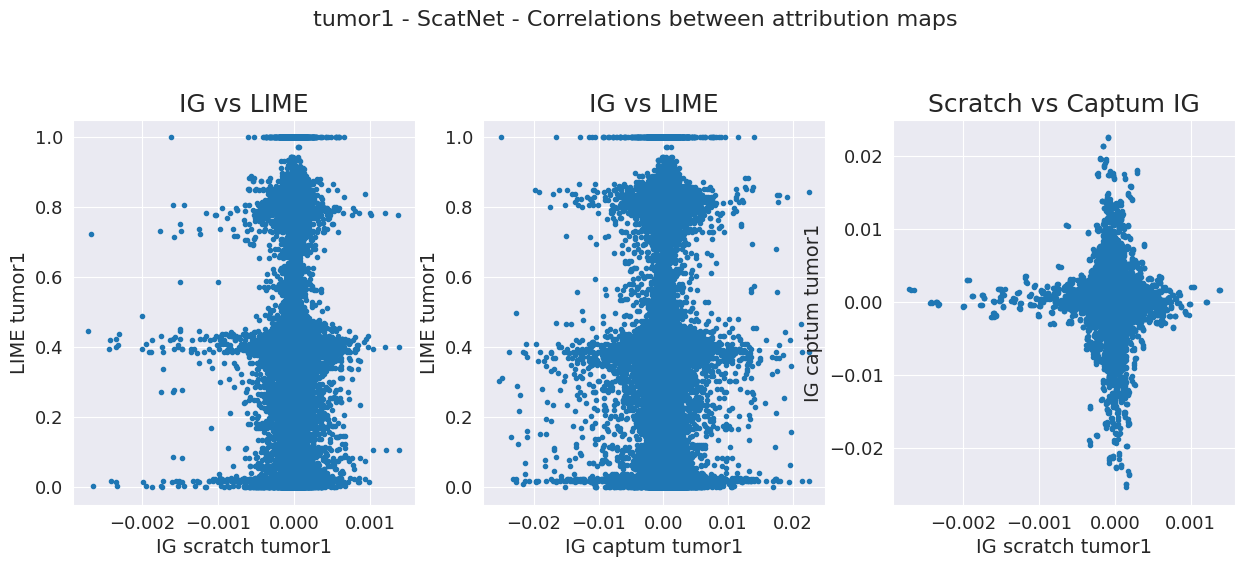

In [58]:
plot_statistics(attribution_scratch_tumor1_ScatNet.cpu().ravel(), lime1_tumor1_ScatNet.ravel(), attribution_captum_tumor1_ScatNet.cpu().ravel(), 
                'tumor1', 'Correlations between attribution maps', 'ScatNet')

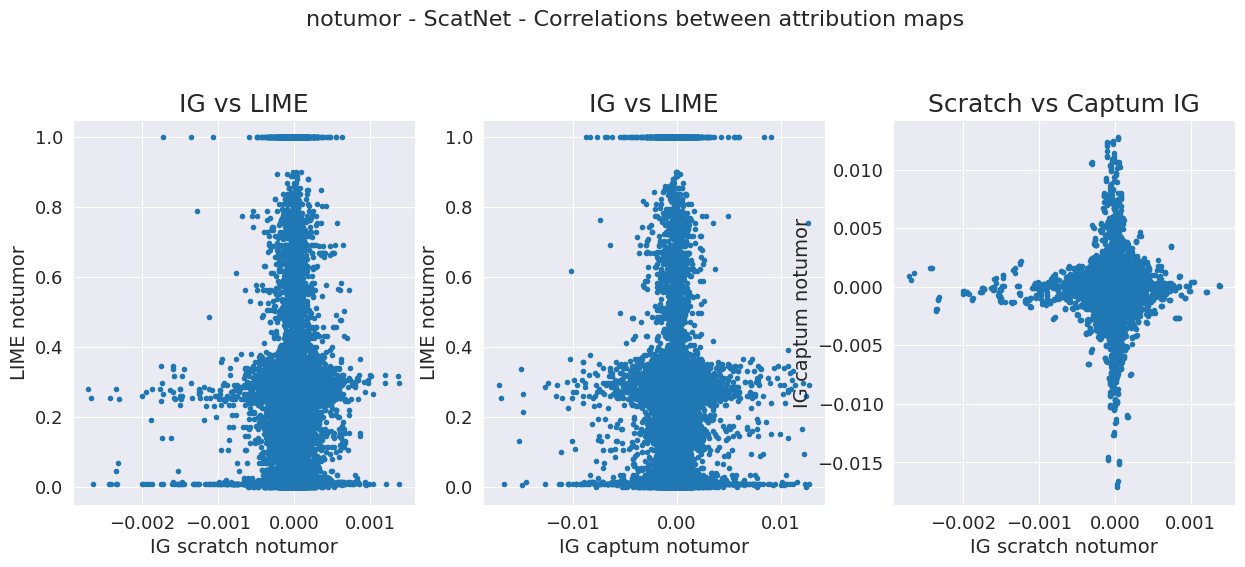

In [59]:
plot_statistics(attribution_scratch_notumor_ScatNet.cpu().ravel(), lime1_notumor_ScatNet.ravel(), attribution_captum_notumor_ScatNet.cpu().ravel(), 
                'notumor', 'Correlations between attribution maps', 'ScatNet')

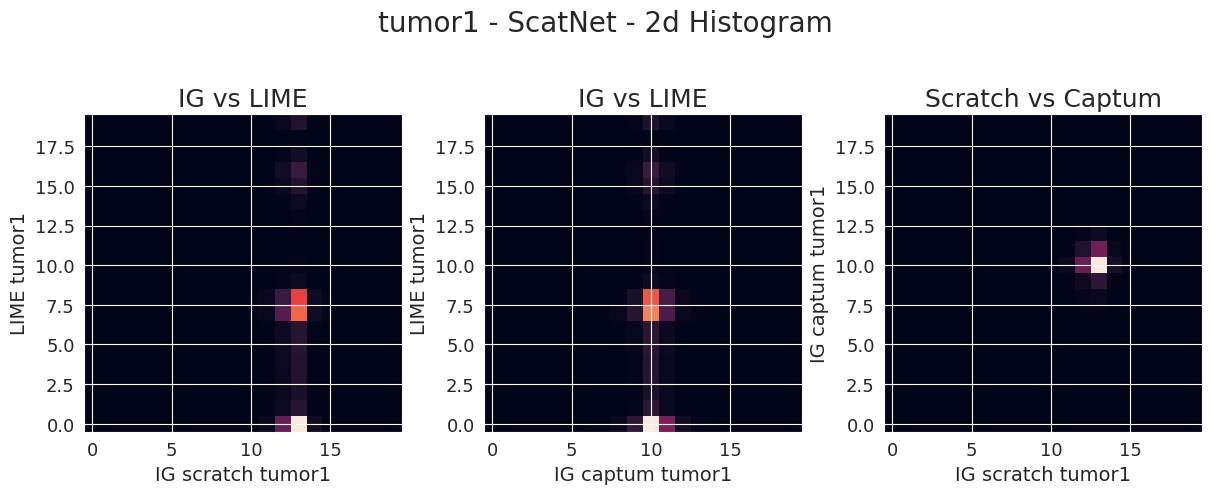

In [60]:
hist_statistics(attribution_scratch_tumor1_ScatNet.cpu().ravel(), lime1_tumor1_ScatNet.ravel(), attribution_captum_tumor1_ScatNet.cpu().ravel(), 
                'tumor1', '2d Histogram', 'ScatNet')

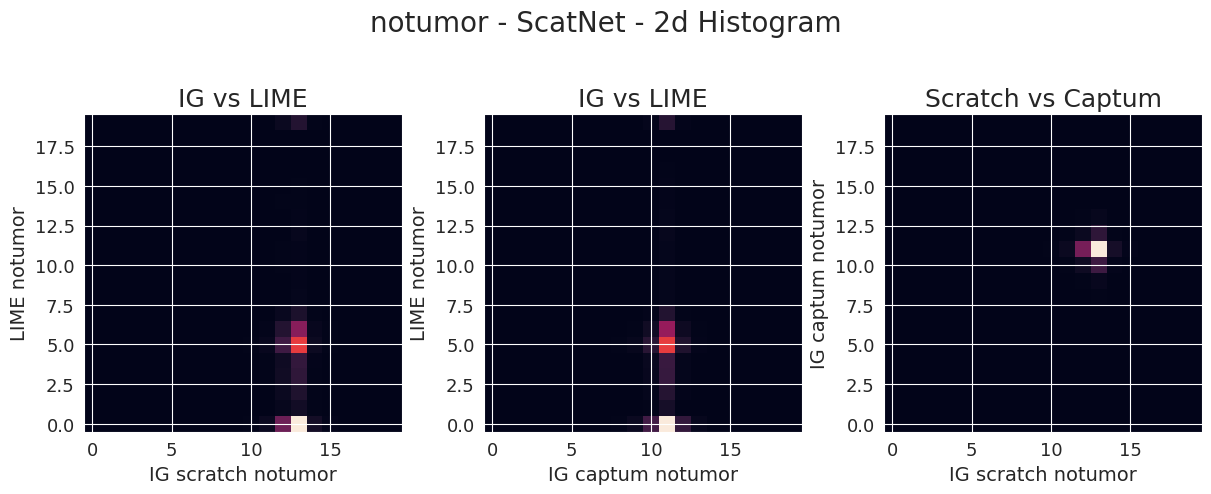

In [61]:
hist_statistics(attribution_scratch_notumor_ScatNet.cpu().ravel(), lime1_notumor_ScatNet.ravel(), attribution_captum_notumor_ScatNet.cpu().ravel(), 
                'notumor', '2d Histogram', 'ScatNet')

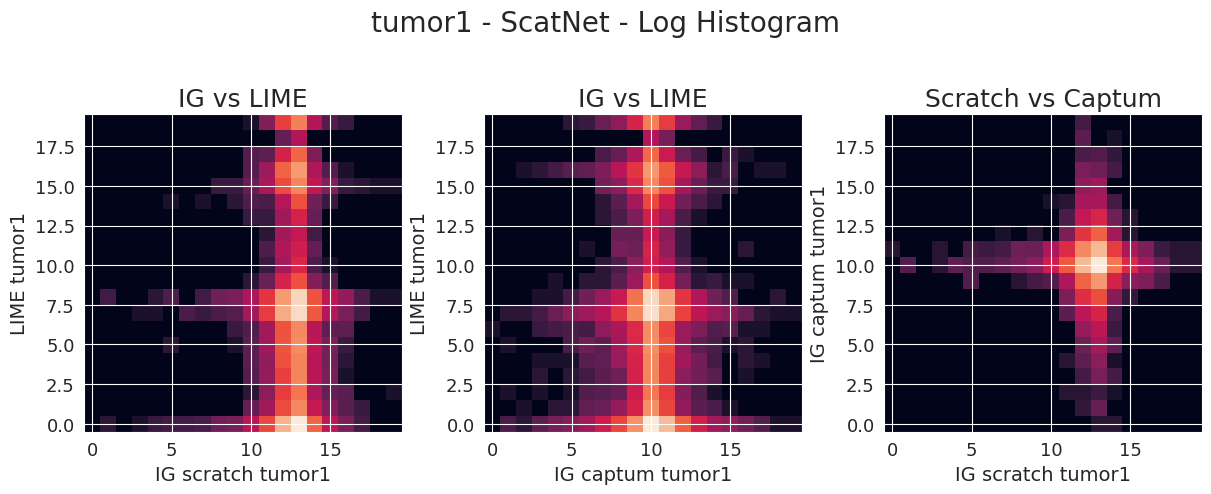

In [62]:
loghist_statistics(attribution_scratch_tumor1_ScatNet.cpu().ravel(), lime1_tumor1_ScatNet.ravel(), attribution_captum_tumor1_ScatNet.cpu().ravel(), 
                'tumor1', 'Log Histogram', 'ScatNet')

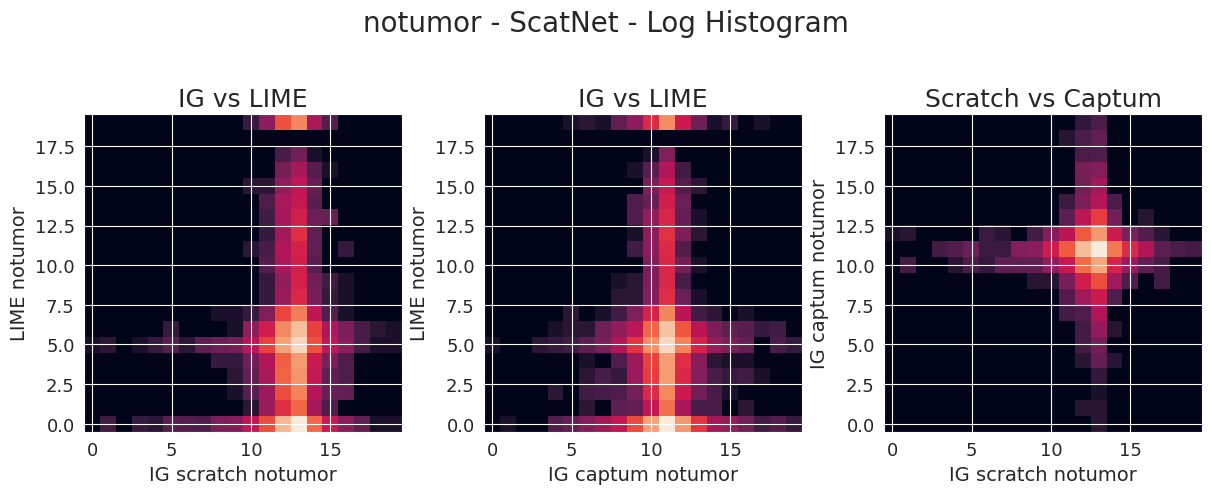

In [63]:
loghist_statistics(attribution_scratch_notumor_ScatNet.cpu().ravel(), lime1_notumor_ScatNet.ravel(), attribution_captum_notumor_ScatNet.cpu().ravel(), 
                'notumor', 'Log Histogram', 'ScatNet')

In [64]:
print('TUMOR MUTUAL INFORMATION SCATNET')
hist_2d, x_edges, y_edges = np.histogram2d(attribution_scratch_tumor1_ScatNet.cpu().ravel(),attribution_captum_tumor1_ScatNet.cpu().ravel(),bins=20)
print("The mutual information between IG Scratch and IG Captum is: ",mutual_information(hist_2d))
hist_2d, x_edges, y_edges = np.histogram2d(attribution_scratch_tumor1_ScatNet.cpu().ravel(),lime1_tumor1_ScatNet.ravel(),bins=20)
print("The mutual information between IG Scratch and LIME is: ",mutual_information(hist_2d))
hist_2d, x_edges, y_edges = np.histogram2d(attribution_captum_tumor1_ScatNet.cpu().ravel(),lime1_tumor1_ScatNet.ravel(),bins=20)
print("The mutual information between IG Captum and LIME is: ",mutual_information(hist_2d))

print('\nNO TUMOR MUTUAL INFORMATION SCATNET')
hist_2d, x_edges, y_edges = np.histogram2d(attribution_scratch_notumor_ScatNet.cpu().ravel(),attribution_captum_notumor_ScatNet.cpu().ravel(),bins=20)
print("The mutual information between IG Scratch and IG Captum is: ",mutual_information(hist_2d))
hist_2d, x_edges, y_edges = np.histogram2d(attribution_scratch_notumor_ScatNet.cpu().ravel(),lime1_notumor_ScatNet.ravel(),bins=20)
print("The mutual information between IG Scratch and LIME is: ",mutual_information(hist_2d))
hist_2d, x_edges, y_edges = np.histogram2d(attribution_captum_notumor_ScatNet.cpu().ravel(), lime1_notumor_ScatNet.ravel(),bins=20)
print("The mutual information between IG Captum and LIME is: ",mutual_information(hist_2d))

TUMOR MUTUAL INFORMATION SCATNET
The mutual information between IG Scratch and IG Captum is:  0.006632982090623742
The mutual information between IG Scratch and LIME is:  0.0062965591725245625
The mutual information between IG Captum and LIME is:  0.007089470359442916

NO TUMOR MUTUAL INFORMATION SCATNET
The mutual information between IG Scratch and IG Captum is:  0.003800007083876287
The mutual information between IG Scratch and LIME is:  0.004584389682910641
The mutual information between IG Captum and LIME is:  0.005998934423735509
